# This notebook is divided into three main sections:
### 1. Data Display, Importing and Preprocessing
### 2. Dimensionality Reduction
### 3. Unsupervised Classification

## 1. Data Display, Importing and Preprocessing

### 1.1 Displaying an RGB image from the given hyperspectral data

Initially, we display the RGB image by combining band# 204, 150 and 0093 as they correspond to the Red, Green and Blue spectrum (as per EO1 User Guide - https://archive.usgs.gov/archive/sites/eo1.usgs.gov/EO1userguidev2pt320030715UC.pdf)

In [190]:
import rasterio
from rasterio.plot import show
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [189]:
# Get list of bands 

stack_band_paths = ["C://Users//Aditya Mohan//Documents//Pixxel//EO1H1430452010208110Kt_1GST//EO1H1430452010208110Kt//EO1H1430452010208110Kt_B204_L1GST.TIF",
             "C://Users//Aditya Mohan//Documents//Pixxel//EO1H1430452010208110Kt_1GST//EO1H1430452010208110Kt//EO1H1430452010208110Kt_B150_L1GST.TIF",
             "C://Users//Aditya Mohan//Documents//Pixxel//EO1H1430452010208110Kt_1GST//EO1H1430452010208110Kt//EO1H1430452010208110Kt_B093_L1GST.TIF"]



In [191]:
# Open the file:
raster1 = rasterio.open(stack_band_paths[0])
raster2 = rasterio.open(stack_band_paths[1])
raster3 = rasterio.open(stack_band_paths[2])

In [192]:
red = raster1.read(1)
green = raster2.read(1)
blue = raster3.read(1)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
0.0 - 1.0 mean: 0.040974584036194445
0.0 - 1.0 mean: 0.10315052899657733
0.0 - 1.0 mean: 0.1258739839157002


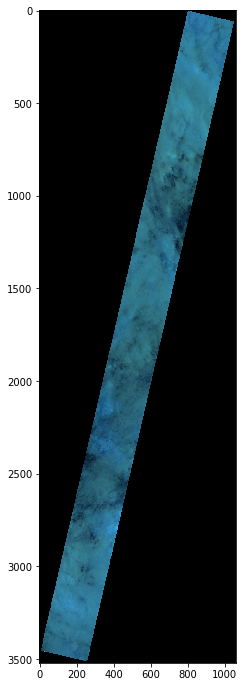

In [164]:
rgb_initial = np.dstack((redn, greenn, bluen))
fig, ax = plt.subplots(figsize=(12, 12))
# Let's see how our color composite looks like
plt.imshow(rgb_initial)

Displayed above is the raw rgb image of three bands in the Red, Green and Blue spectrum respectively.

### 1.2 Importing and pre-processing input data


Here, I import data from my local storage. The images pixel range is 16 bits and the format is TIFF and hence, it is imported through the tifffile library. 
Before importing the images,  we check if the number of non zero pixels are below a certain threshold. It indicates it is a low resolution/ bad band and we don't consider them in our analysis. During importing, we call the function - correct_image (created before) to rotate and crop the unecessary background pixels.

In [8]:
from PIL import Image

In [9]:
# Function to crop image

def crop(image):
    y_nonzero, x_nonzero = np.nonzero(image)
    return image[0:3520, 400:650]

In [10]:
# Function to rotate image and crop to obtain a better display and extract important features of the image

def correct_image(image, angle_of_rotation):
    im_pil = Image.fromarray(image)
    rotated     = im_pil.rotate(angle_of_rotation)
    segmented_image = np.asarray(rotated)
    cropped_image = crop(segmented_image)
    rows,cols = cropped_image.shape
    return cropped_image, rows, cols

In [11]:
# Importing data from a local folder

import tifffile as tiff
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

X_data = []
files = glob.glob ("C://Users//Aditya Mohan//Documents//Pixxel//EO1H1430452010208110Kt_1GST//EO1H1430452010208110Kt//*.TIF")
for myFile in files:

    image = cv2.imread(myFile,0)
    # Detecting bad bands if the ratio of non black pixels are less than 8% of the enitre image and neglecting them
    rows ,columns = image.shape
    if (cv2.countNonZero(image) < (0.08 * rows * columns )):
        continue
        
    image = tiff.imread(myFile)
    im,_,_ = correct_image(image,13)
    X_data.append(im)


In [13]:
# Converting list into an array
X_train_array = np.array(X_data)
print(X_train_array.shape)

(161, 3520, 250)


In [14]:
#Flattening the array

dims, orig_rows, orig_cols = X_train_array.shape
X_flat = X_train_array.reshape((dims, orig_rows*orig_cols))
print(X_flat.shape)

(161, 880000)


In [15]:
# Transposing to select principal components of the band dimension

X_flat_transposed = np.transpose(X_flat)
print(X_flat_transposed.shape)

(880000, 161)


In [16]:
X_flat.shape

(161, 880000)

## 2. Dimensionality Reduction

### 2.1 Principle Component Analysis

We use Principal Component analysis to reduce the dimension of the remaining 161 bands into just 5 principle components. This is done using the Incremental PCA function imported from the Scikit-learn library. Incremental PCA is chosen because of the large number of features in the input data and would work well running it in small batches.


In [17]:
#Using the IncrementalPCA method from the scikit-learn library

from sklearn.decomposition import IncrementalPCA

IPCA = IncrementalPCA(n_components=5, batch_size = 5)
X_IPCA = IPCA.fit_transform(X_flat_transposed)

print(X_IPCA.shape)

C:\Users\Anaconda3\lib\site-packages\sklearn\decomposition\_incremental_pca.py:313: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
C:\Users\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(880000, 5)


In [18]:
#Array is transposed to be consistent with the original format

X_IPCA = np.transpose(X_IPCA)
X_IPCA.shape

(5, 880000)

In [372]:
PC0=  X_IPCA[0].reshape(orig_rows,orig_cols)
PC1=  X_IPCA[1].reshape(orig_rows,orig_cols)
PC2=  X_IPCA[2].reshape(orig_rows,orig_cols)

In [369]:
PC_List = [PC0,PC1,PC2]

### 2.2 Displaying Principle Components

Here, we display the first three principle components and later display the stacked image - which would be the one we will be segmenting later on.

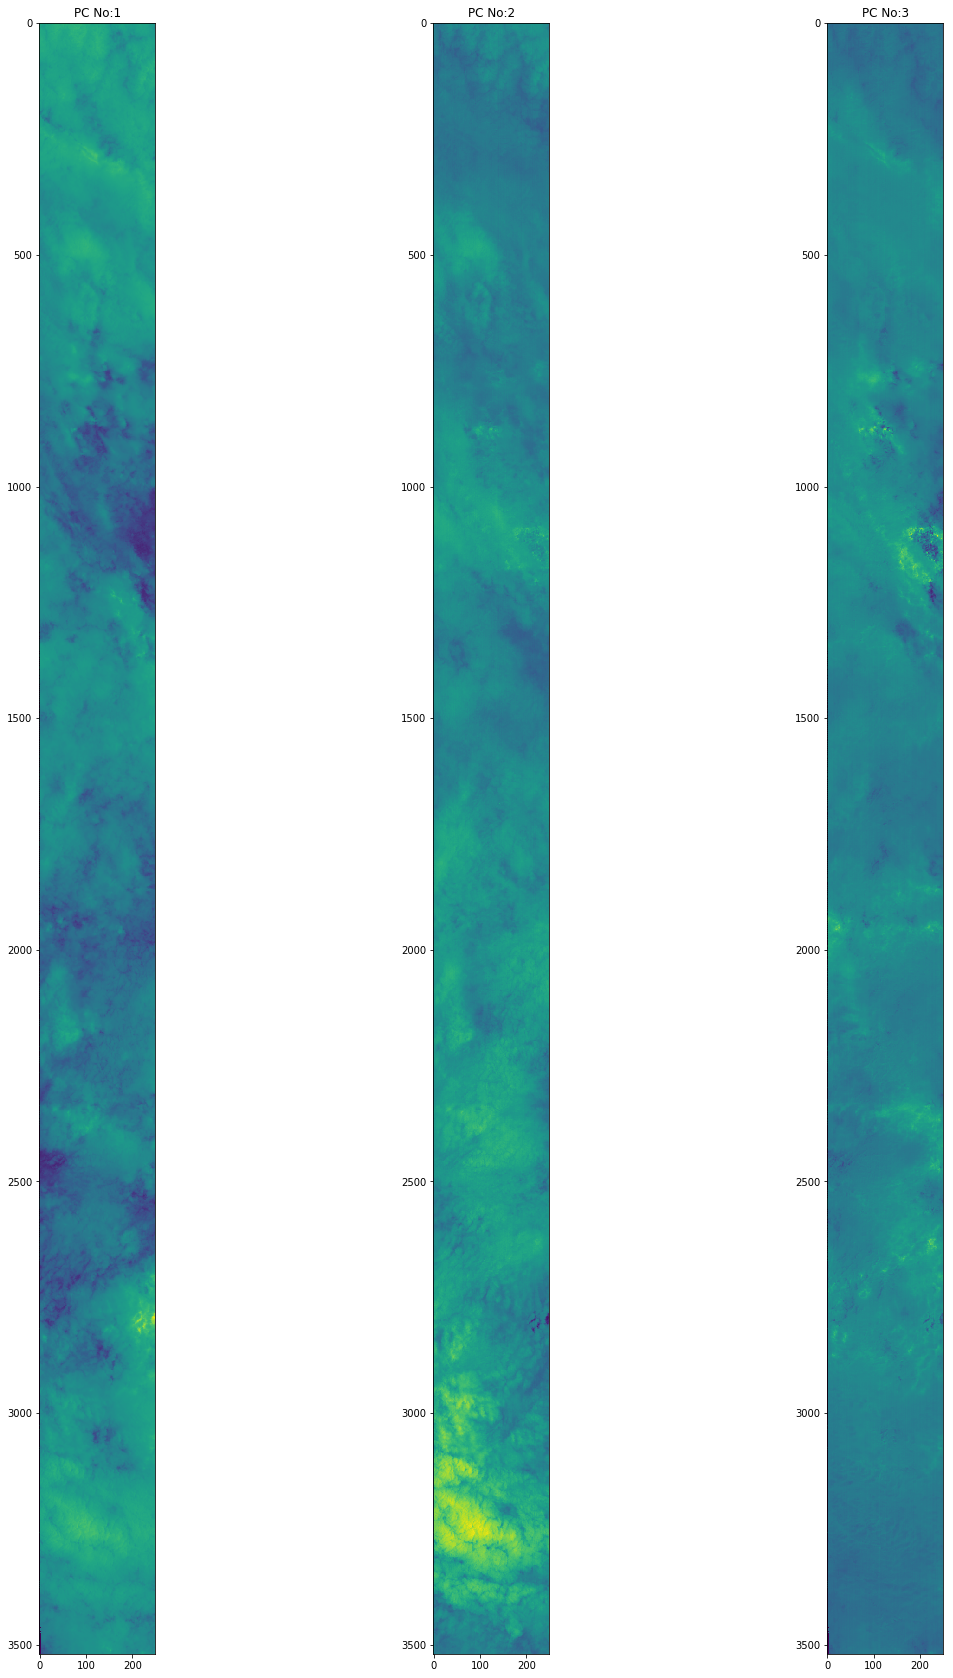

In [373]:

fig = plt.figure(figsize=(20, 30))
for PC_No in range(0,3):
  
    a = fig.add_subplot(1,3,PC_No+1)  
    i = PC_No+1
    a.set_title("PC No:{}".format(i))
    plt.imshow(PC_List[PC_No])
    
    
    
plt.show()    

The first three Principal Components are displayed here


In [310]:
red = PC0
green = PC1
blue = PC2

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
0.0 - 1.0 mean: 0.4557954994839381
0.0 - 1.0 mean: 0.5008612457034906
0.0 - 1.0 mean: 0.4460435221977906


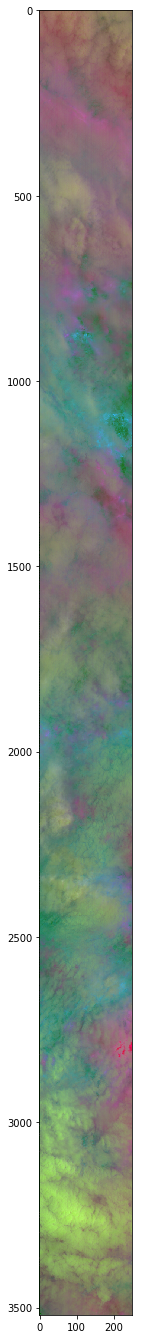

In [320]:
rgb_PC = np.dstack((redn, greenn, bluen))
fig, ax = plt.subplots(figsize=(24, 24))
# Let's see how our color composite looks like
plt.imshow(rgb_PC)

Here we display the stacked RGB image of the three PCs

## 3. Unsupervised Classification

### 3.1 Number of Clusters
Here, we use the elbow method to find the optimal value of the number of clusters used for image segmentation through the unsupervised K-means algorithm. Upon obtaining the value, we use it to segment 3 of the most import principal components.

In [24]:
from PIL import Image

In [393]:
vectorized =rgb_PC.reshape((new_rows*new_cols), 3)
print(vectorized.shape)

(880000, 3)


In [394]:

from sklearn.cluster import KMeans

score = []

for cluster in range(2,10):
    kmeans = KMeans(n_clusters = cluster, init="k-means++", random_state=10)
    kmeans.fit(vectorized)
    score.append(kmeans.inertia_)

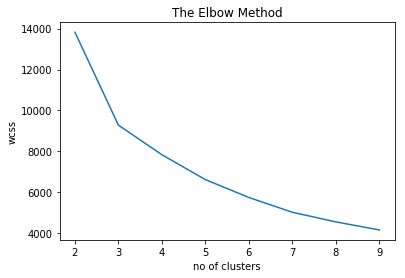

In [396]:
# Plotting the score

plt.plot(range(2,10), score)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the inertia start decreasing in a linear fashion. 
Thus for the given data, we conclude that the optimal number of clusters for the data is 3.

### 3.2  Segmentation of Principal Components 

Here, we individually segment the three primary Principal Components separately

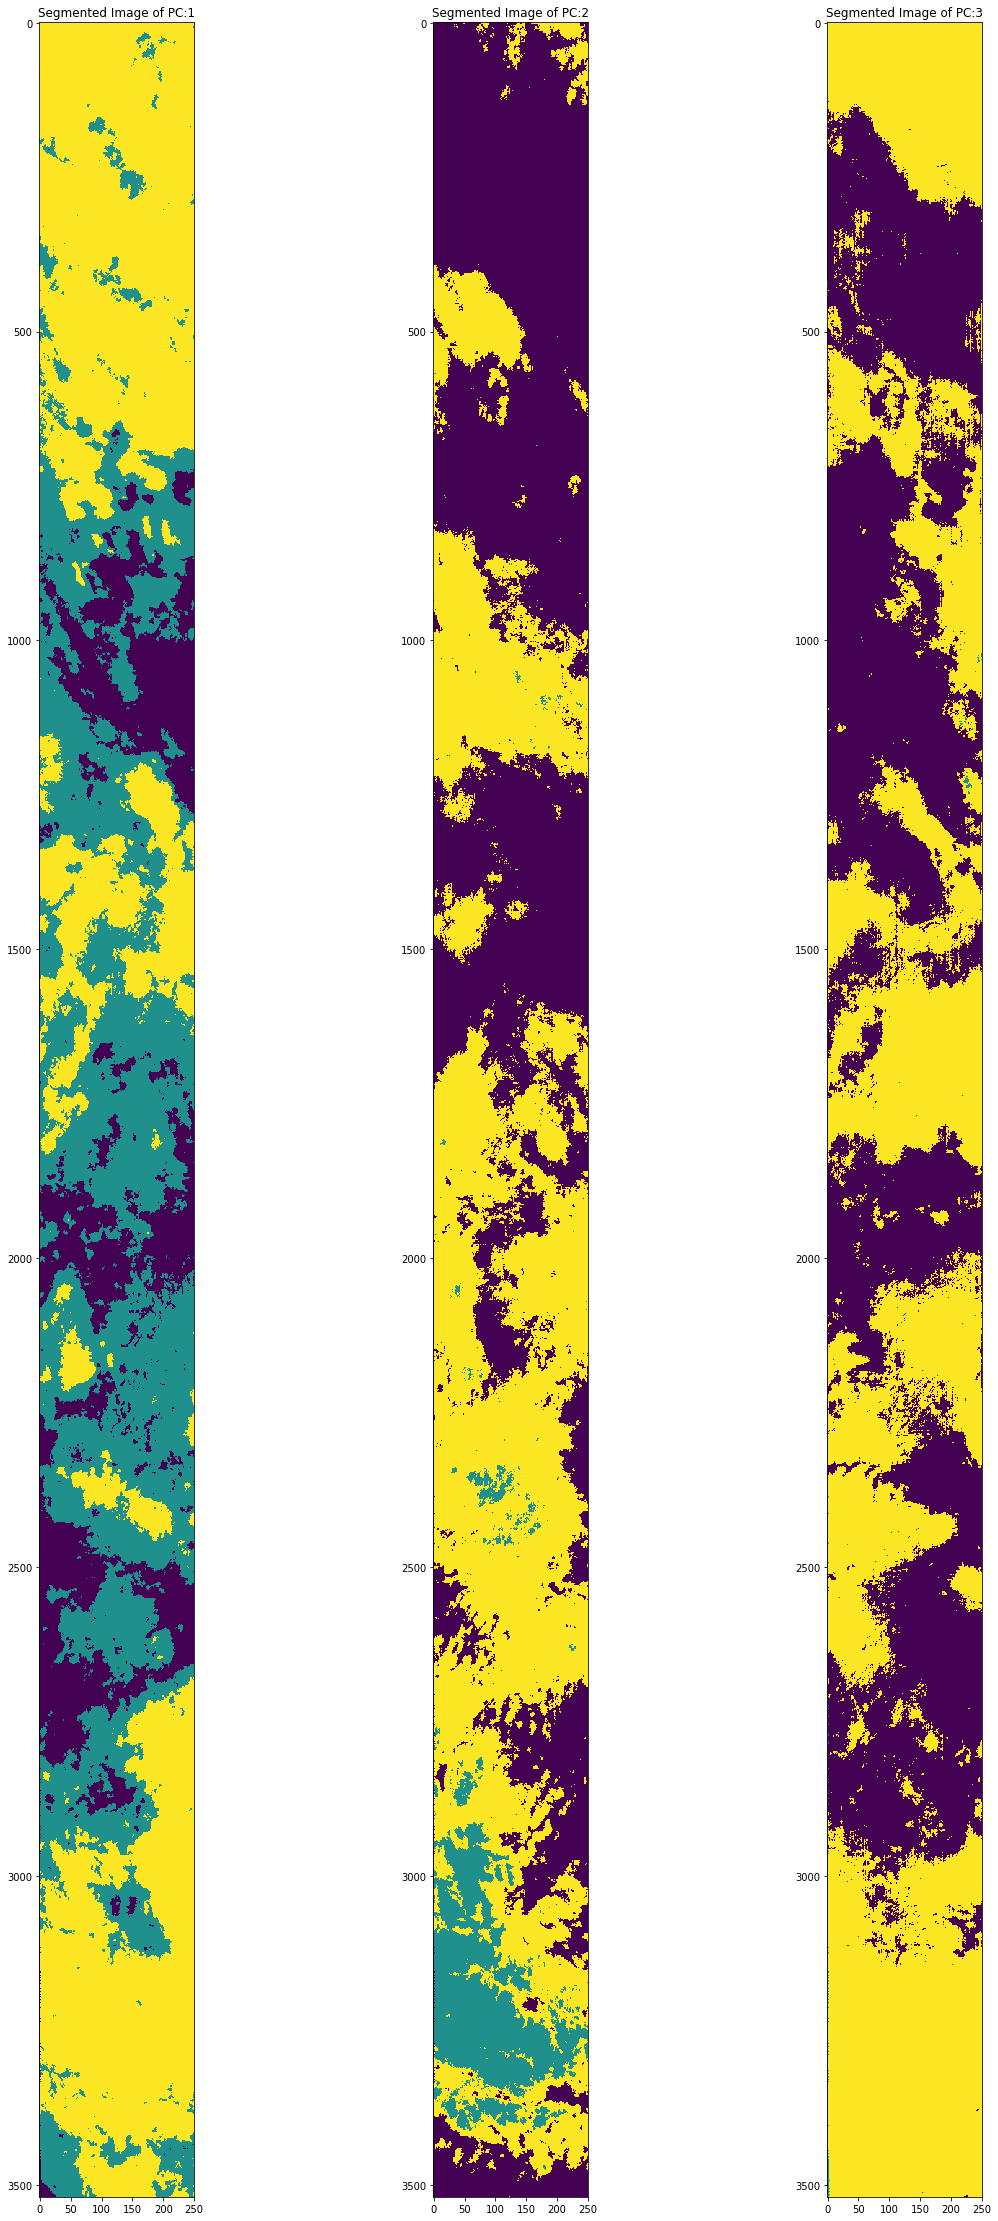

In [397]:
#Run KMeans to Segment the first four principle components

fig = plt.figure(figsize=(20, 40))
segmented_images = []
kmeans = KMeans(random_state=0, init='random', n_clusters=3)
for PC_No in range(0,3):
    
    vectorized = PC_List[PC_No].reshape((new_rows*new_cols), 1)
    labels = kmeans.fit_predict(vectorized)
    
    segmented_image = labels.reshape(new_rows,new_cols)
    segmented_images.append(segmented_image)
    a = fig.add_subplot(1,3,PC_No+1)  
    i = PC_No+1
    a.set_title("Segmented Image of PC:{}".format(i))
    plt.imshow(segmented_image)
    
    
    
plt.show()    

Here, we have obtained the first three principle components of the dataset. From here on, we'll use these three already segmented bands and merge them in order to create a false color image, which would be the final segmented image that we require.

First, we'll measure the clustering performance using the davies_bouldin evaluation metric. The image used is the first principle component for this purpose

In [398]:
#We use the davies_bouldin_score as a clustering performance metric

from sklearn.metrics import davies_bouldin_score
score = davies_bouldin_score(vectorized, labels)
print(score)

0.46086163371621486


### 3.2 RGB Stacking 

Finally, we stack the segmented Principal Components and compare it with the initial RGB image by its side

In [399]:
# Get list of bands 
stack_band_paths = ["C://Users//Aditya Mohan//Documents//Pixxel//EO1H1430452010208110Kt_1GST//EO1H1430452010208110Kt//EO1H1430452010208110Kt_B204_L1GST.TIF",
             "C://Users//Aditya Mohan//Documents//Pixxel//EO1H1430452010208110Kt_1GST//EO1H1430452010208110Kt//EO1H1430452010208110Kt_B150_L1GST.TIF",
             "C://Users//Aditya Mohan//Documents//Pixxel//EO1H1430452010208110Kt_1GST//EO1H1430452010208110Kt//EO1H1430452010208110Kt_B093_L1GST.TIF"]
# Open the file:
raster1_1 = rasterio.open(stack_band_paths[0])
raster2_1 = rasterio.open(stack_band_paths[1])
raster3_1= rasterio.open(stack_band_paths[2])


In [400]:
raster1_2,r,c = correct_image(raster1_1.read(1),13)
raster2_2,r,c = correct_image(raster2_1.read(1),13)
raster3_2,r,c = correct_image(raster3_1.read(1),13)

In [401]:
np.array(raster2_2).shape

(3520, 250)

In [402]:
red = raster1_2
green = raster2_2
blue = raster3_2

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redni = normalize(red)
greenni = normalize(green)
blueni = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
0.0 - 1.0 mean: 0.4557954994839381
0.0 - 1.0 mean: 0.5008612457034906
0.0 - 1.0 mean: 0.4460435221977906


In [403]:
red = segmented_images[0]
green = segmented_images[1]
blue = segmented_images[2]

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
rednf = normalize(red)
greennf = normalize(green)
bluenf = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
0.0 - 1.0 mean: 0.4557954994839381
0.0 - 1.0 mean: 0.5008612457034906
0.0 - 1.0 mean: 0.4460435221977906


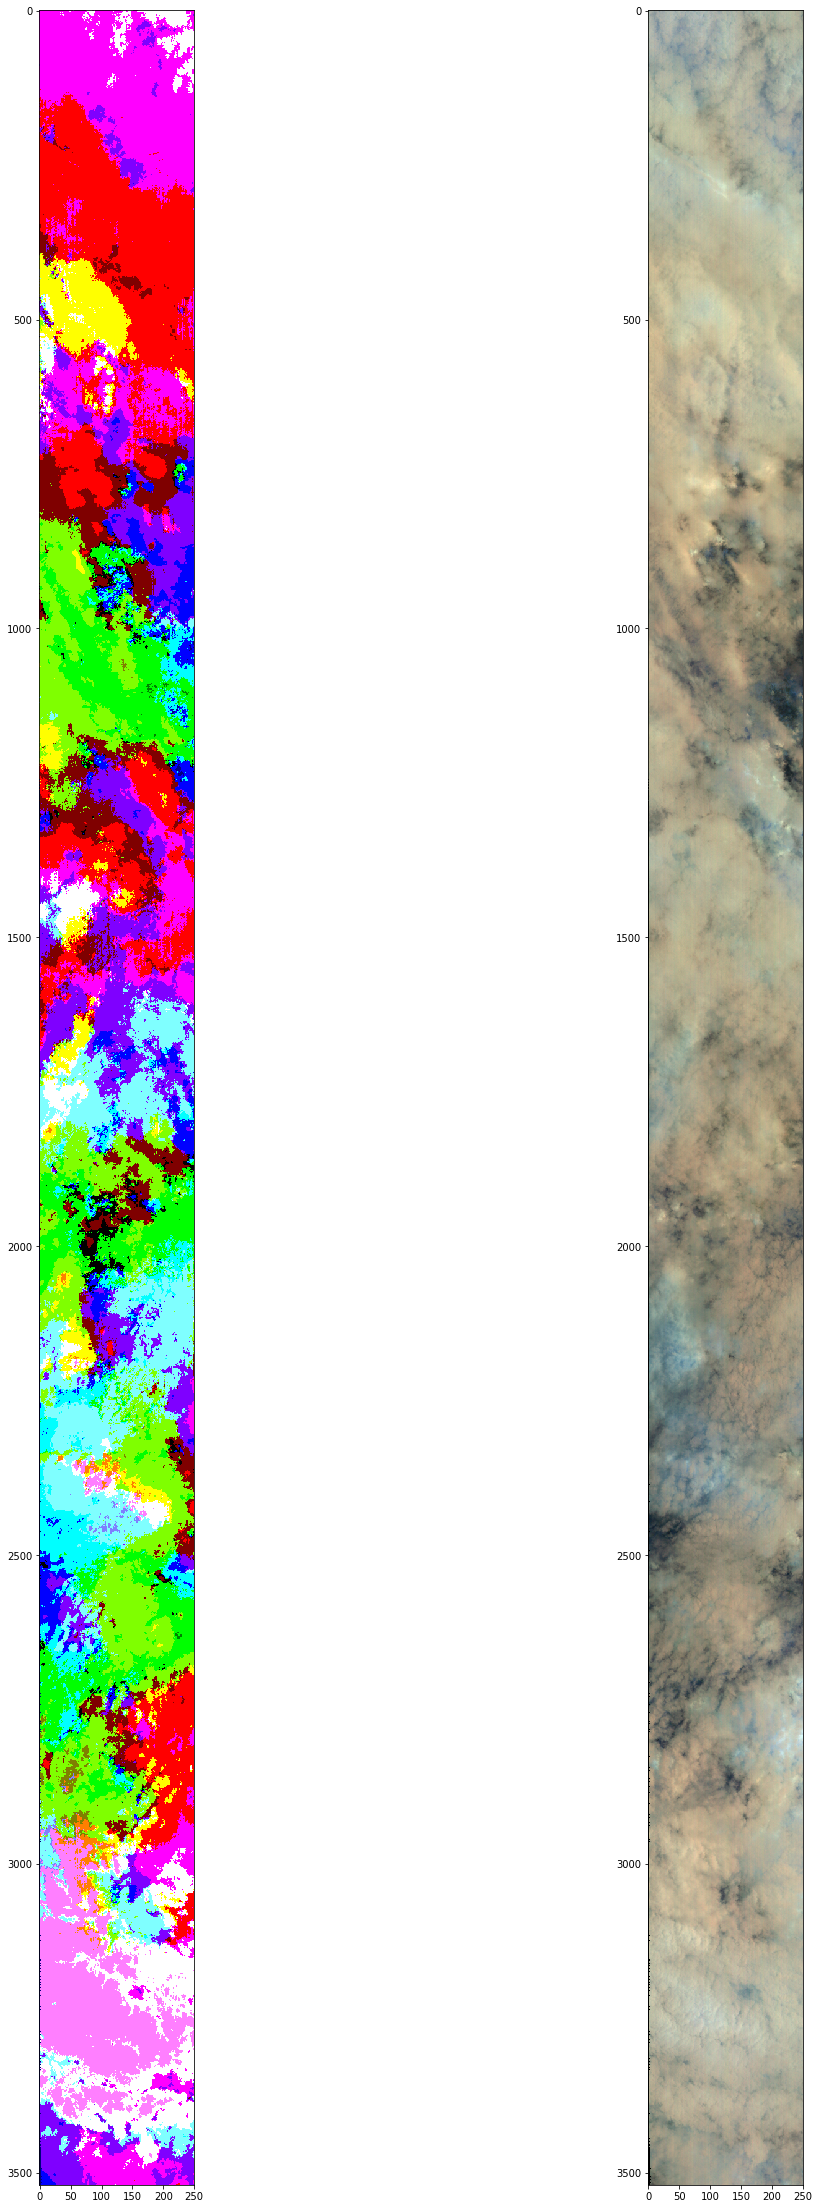

In [404]:
rgb_initial = np.dstack((redni, greenni, blueni))
rgb_final = np.dstack((rednf, greennf, bluenf))

fig = plt.figure(figsize=(20, 40))
# Let's see how our color composite looks like
a = fig.add_subplot(1,2,1)
plt.imshow(rgb_final)

a = fig.add_subplot(1,2,2)
plt.imshow(rgb_initial)

plt.show()

To the left is the final segmented false colour RGB image and to the right is the initial RGB image.